<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 37
# Student 1: Jiong Li | 1533312
# Student 2: Peter Elmers | 1734350
# Student 3: P.T.C.M. Tholhuijsen | 1237447

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

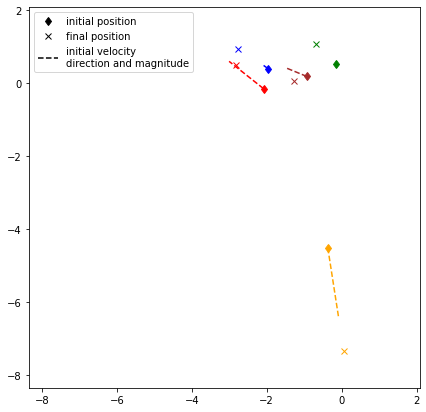

In [7]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [8]:
# Pick the best device
import torch

def try_device(device):
    # Try to put an array on given device. If successful, return device. Else, 'cpu'.
    x = torch.ones((1,))
    try:
        x.to(device)
        return device
    except:
        return 'cpu'

device = try_device('cuda')
if device == 'cpu':
    device = try_device('mps')

print(f'Device is set to {device}')

# Move all the little craps into torch things on the device
p_train, v_train, c_train = [torch.Tensor(vec).to(device=device) for vec in [positions_train, velocities_train, charges_train]]
p_valid, v_valid, c_valid = [torch.Tensor(vec).to(device=device) for vec in [positions_valid, velocities_valid, charges_valid]]
p_test, v_test, c_test = [torch.Tensor(vec).to(device=device) for vec in [positions_test, velocities_test, charges_test]]

Device is set to cuda


In [9]:
# Create a baseline: particle position = velocity * time + initial
def baseline_predict(p0, v0, time):
    '''
    Return a numpy array of predicted x, y position of each particle in p0.
    Given p0 starting locations, v0 starting velocities, and time to predict.
    Result is computed via linear projection: v0 * time + p0.
    Where p0 and v0 are both (N x 1 x 2 x P) tensors, for N simulations, P particles/sim
    '''
    return p0 + v0 * time


# Preprocessing dataset

In [ ]:
# p_train, v_train, c_train = p_train[:2000], v_train[:2000], c_train[:2000]
# p_valid, v_valid, c_valid = p_valid[:400], v_valid[:400], c_valid[:400]

In [10]:
# transpose the position, velocity (at t=0) and charge into the row for each particle
# : x_i = (pos_x,pos_y,vel_x,vel_y,charge)
# transpose the position at each time point(t1=0.5s, t2=1s, t3=1.5s) into the row for each particle
# : y_i = (pos_t1,pos_t2,pos_t3)

train_dataset_x, train_dataset_y = list(), list()

for i in zip(p_train, v_train, c_train):
    p = torch.transpose(i[0][0], 0, 1)
    v = torch.transpose(i[1][0], 0, 1)
    c = i[2]
    
    train_dataset_x.append(torch.hstack((p, v, c)))
    train_dataset_y.append(torch.hstack((torch.transpose(i[0][1], 0, 1), 
                           torch.transpose(i[0][2], 0, 1), 
                           torch.transpose(i[0][3], 0, 1))))
    

val_dataset_x, val_dataset_y = list(), list()

for i in zip(p_valid, v_valid, c_valid):
    p = torch.transpose(i[0][0], 0, 1)
    v = torch.transpose(i[1][0], 0, 1)
    c = i[2]
    
    val_dataset_x.append(torch.hstack((p, v, c)))
    val_dataset_y.append(torch.hstack((torch.transpose(i[0][1], 0, 1), 
                         torch.transpose(i[0][2], 0, 1), 
                         torch.transpose(i[0][3], 0, 1))))
    

test_dataset_x, test_dataset_y = list(), list()

for i in zip(p_test, v_test, c_test):
    p = torch.transpose(i[0][0], 0, 1)
    v = torch.transpose(i[1][0], 0, 1)
    c = i[2]
    
    test_dataset_x.append(torch.hstack((p, v, c)))
    test_dataset_y.append(torch.hstack((torch.transpose(i[0][1], 0, 1), 
                          torch.transpose(i[0][2], 0, 1), 
                          torch.transpose(i[0][3], 0, 1))))

In [11]:
from torch.utils.data import Dataset, DataLoader


class mySecondDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [ ]:
# show the item in mySecondDataset
tmp = mySecondDataset(train_dataset_x, train_dataset_y)
x,y = tmp.__getitem__(0)
y.shape

torch.Size([5, 6])

In [12]:
# apply the DataLoader to the training dataset, validation dataset and test dataset
trainLoader = DataLoader(mySecondDataset(train_dataset_x, train_dataset_y), batch_size=10, shuffle=True)
validationLoader = DataLoader(mySecondDataset(val_dataset_x, val_dataset_y), batch_size=10, shuffle=True)
testLoader = DataLoader(mySecondDataset(test_dataset_x, test_dataset_y), batch_size=10, shuffle=True)

# Model Implementation

In [13]:
import torch.nn as nn
from tqdm import tqdm

Implementation like https://github.com/higgsfield/interaction_network_pytorch/blob/master/Interaction%20Network.ipynb

In [ ]:
for i in zip(p_train, v_train, c_train):
    p = torch.transpose(i[0][0], 0, 1)
    v = torch.transpose(i[1][0], 0, 1)
    c = i[2]
   
    data = torch.hstack((p, v, c))
    print(data)
    print(data[:, 0:2])
    print(data[:, 2:4])
    # x_p, y_p, x_v, y_v, c
    break

tensor(-1.9361, device='cuda:0')
tensor([[-1.9361, -0.2276, -0.7878,  0.0267, -1.0000],
        [ 3.6532, -2.7631,  1.5892, -0.4211,  1.0000],
        [-4.5496,  8.2998, -1.2906,  2.3834,  1.0000],
        [-3.0958, -3.0921, -1.9173, -0.5785,  1.0000],
        [ 0.1073, -2.8976,  0.6539, -0.5676, -1.0000]], device='cuda:0')
tensor([[-1.9361, -0.2276],
        [ 3.6532, -2.7631],
        [-4.5496,  8.2998],
        [-3.0958, -3.0921],
        [ 0.1073, -2.8976]], device='cuda:0')
tensor([[-0.7878,  0.0267],
        [ 1.5892, -0.4211],
        [-1.2906,  2.3834],
        [-1.9173, -0.5785],
        [ 0.6539, -0.5676]], device='cuda:0')


In [ ]:
len(next(iter(trainLoader)))

2

In [14]:
# object-centric acceleration neural network
class AccelerationModel(nn.Module):
    def __init__(self):
        super(AccelerationModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(5, 25),
            nn.ReLU(),
            
            nn.Linear(25, 125),
            nn.ReLU(),
            nn.Linear(125, 625),
            nn.ReLU(),
            
            nn.Dropout(p=0.2),
            nn.Linear(625, 2),
        )
        
    def forward(self, x):
        x = x.view(-1, 5)
        x = self.layers(x)
        return x.view(10, 5, 2)

In [15]:
# object-centric velocity neural network
class VelocityModel(nn.Module):
    def __init__(self):
        super(VelocityModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(4, 16),
            # nn.Dropout(p=0.2),
            nn.ReLU(),
            
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            
            nn.Linear(256, 2),
        )
        
    def forward(self, x):
        x = x.view(-1, 4)
        x = self.layers(x)
        return x.view(10, 5, 2)

In [16]:
# object-centric position neural network
class PositionModel(nn.Module):
    def __init__(self):
        super(PositionModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            
            nn.Linear(256, 2),
        )
        
    def forward(self, x):
        x = x.view(-1, 4)
        x = self.layers(x)
        return x.view(10, 5, 2)

In [18]:
# interaction network
class InteractionNetwork(nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()
        
        self.acceleration_model = AccelerationModel()
        self.velocity_model = VelocityModel()
        self.position_model = PositionModel()
        
    def forward(self, x, delta_t):
        pred_accelleration = self.acceleration_model(x)
        pred_velocity = self.velocity_model(torch.dstack((x[:, :, 2:4], torch.mul(pred_accelleration, delta_t))))
        pred_position = self.position_model(torch.dstack((x[:, :, 0:2], pred_velocity)))
        return pred_position
    
interaction_network = InteractionNetwork()
interaction_network.to(device=device)

InteractionNetwork(
  (acceleration_model): AccelerationModel(
    (layers): Sequential(
      (0): Linear(in_features=5, out_features=25, bias=True)
      (1): ReLU()
      (2): Linear(in_features=25, out_features=125, bias=True)
      (3): ReLU()
      (4): Linear(in_features=125, out_features=625, bias=True)
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Linear(in_features=625, out_features=2, bias=True)
    )
  )
  (velocity_model): VelocityModel(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (position_model): PositionModel(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_featu

In [19]:
sum(p.numel() for p in interaction_network.parameters() if p.requires_grad)

120046

In [23]:
def evaluation(model, test_loader, klass):
    model = model.eval()
    loss_t1, loss_t2, loss_t3, loss_tot = list(), list(), list(), list()

    with torch.no_grad():
        for x, y in test_loader:
            pred_p_t1 = model(x, 0.5)
            loss1 = criterion(pred_p_t1, y[:, :, 0:2])

            pred_p_t2 = model(x, 1.0)
            loss2 = criterion(pred_p_t2, y[:, :, 2:4])

            pred_p_t3 = model(x, 1.5)
            loss3 = criterion(pred_p_t3, y[:, :, 4:6])

            # loss1 = criterion(pred_p_t1,y[:,:,0:2])
            # loss2 = criterion(pred_p_t2,y[:,:,2:4])
            # loss3 = criterion(pred_p_t3,y[:,:,4:6])

            loss_t1.append(loss1.item() / 10)
            loss_t2.append(loss2.item() / 10)
            loss_t3.append(loss3.item() / 10)

            y_pred = torch.dstack((pred_p_t1, pred_p_t2, pred_p_t3))
            loss = criterion(y_pred, y)
            loss_tot.append(loss.item() / 10)

    print(f'Average loss in totall: {round(sum(loss_tot)/len(test_loader),5)}')
    print(f'Average loss in {klass} at time= 0.5: {round(sum(loss_t1)/len(test_loader),5)}')
    print(f'Average loss in {klass} at time= 1: {round(sum(loss_t2)/len(test_loader),5)}')
    print(f'Average loss in {klass} at time= 1.5: {round(sum(loss_t3)/len(test_loader),5)}\n')

In [21]:
optimizer = torch.optim.SGD(interaction_network.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.L1Loss()
criterion.to(device=device)

train_loss_graph, val_loss_graph = list(), list()
for epoch in range(50):
    train_loss, val_loss = list(), list()
    
    interaction_network = interaction_network.train()
    for x_train, y_train in tqdm(trainLoader, desc="Training"):
        optimizer.zero_grad()
        pred_p_t1 = interaction_network(x_train, 0.5)
        loss_t1 = criterion(pred_p_t1, y_train[:, :, 0:2])
        loss_t1.backward()
        optimizer.step()
        
        pred_p_t2 = interaction_network(x_train, 1.0)
        loss_t2 = criterion(pred_p_t2, y_train[:, :, 2:4])
        loss_t2.backward()
        optimizer.step()
        
        pred_p_t3 = interaction_network(x_train, 1.5)
        loss_t3 = criterion(pred_p_t3, y_train[:, :, 4:6])
        loss_t3.backward()
        optimizer.step()
        
        # y_pred = torch.dstack((pred_p_t1, pred_p_t2, pred_p_t3))
        # loss = criterion(y_pred, y_train)

        # loss.backward()
        # optimizer.step()
        
        train_loss.append(sum([loss_t1.item(), loss_t2.item(), loss_t3.item()]) / 10)

    train_loss_graph.append(sum(train_loss) / len(trainLoader))
    
    interaction_network = interaction_network.eval()
    for x_val, y_val in validationLoader:
        optimizer.zero_grad()
        pred_p_t1 = interaction_network(x_val, 0.5)
        loss_t1 = criterion(pred_p_t1, y_val[:, :, 0:2])
        
        pred_p_t2 = interaction_network(x_val, 1.0)
        loss_t2 = criterion(pred_p_t2, y_val[:, :, 2:4])
        
        pred_p_t3 = interaction_network(x_val, 1.5)
        loss_t3 = criterion(pred_p_t3, y_val[:, :, 4:6])
        
        
        # y_pred = torch.dstack((pred_p_t1, pred_p_t2, pred_p_t3))
        # loss = criterion(y_pred, y_val)
        
        val_loss.append(sum([loss_t1.item(), loss_t2.item(), loss_t3.item()]) / 10)
    
    val_loss_graph.append(sum(val_loss) / len(validationLoader))
    
    print(f'Average loss: {round(train_loss_graph[-1],5)}')
    print(f'val loss: {round(val_loss_graph[-1],5)}\n')

test_loss = list()
interaction_network = interaction_network.eval()
for x_test, y_test in testLoader:
    optimizer.zero_grad()
    pred_p_t1 = interaction_network(x_test, 0.5)
    loss_t1 = criterion(pred_p_t1, y_test[:, :, 0:2])
                        
    pred_p_t2 = interaction_network(x_test, 1.0)
    loss_t2 = criterion(pred_p_t2, y_test[:, :, 2:4])
    
    pred_p_t3 = interaction_network(x_test, 1.5)
    loss_t3 = criterion(pred_p_t3, y_test[:, :, 4:6])
    
    # y_pred = torch.dstack((pred_p_t1, pred_p_t2, pred_p_t3))
    # loss = criterion(y_pred, y_test)
        
    test_loss.append(sum([loss_t1.item(), loss_t2.item(), loss_t3.item()]) / 10)
    
print(f"test loss:{round(sum(test_loss) / len(testLoader),5)}")

Training: 100%|██████████| 1000/1000 [00:09<00:00, 108.21it/s]


Average loss: 0.15808
val loss: 0.11513



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.06it/s]


Average loss: 0.11111
val loss: 0.10776



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.86it/s]


Average loss: 0.09951
val loss: 0.09055



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.25it/s]


Average loss: 0.08487
val loss: 0.07544



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.33it/s]


Average loss: 0.0735
val loss: 0.07814



Training: 100%|██████████| 1000/1000 [00:09<00:00, 108.34it/s]


Average loss: 0.06984
val loss: 0.0677



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.88it/s]


Average loss: 0.06779
val loss: 0.06558



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.94it/s]


Average loss: 0.0662
val loss: 0.06655



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.92it/s]


Average loss: 0.06447
val loss: 0.06284



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.62it/s]


Average loss: 0.06333
val loss: 0.06603



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.12it/s]


Average loss: 0.06218
val loss: 0.06385



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.80it/s]


Average loss: 0.06196
val loss: 0.06606



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.86it/s]


Average loss: 0.06134
val loss: 0.06409



Training: 100%|██████████| 1000/1000 [00:09<00:00, 111.04it/s]


Average loss: 0.06072
val loss: 0.0598



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.56it/s]


Average loss: 0.06038
val loss: 0.05987



Training: 100%|██████████| 1000/1000 [00:08<00:00, 111.68it/s]


Average loss: 0.06058
val loss: 0.05941



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.86it/s]


Average loss: 0.05984
val loss: 0.06205



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.63it/s]


Average loss: 0.05976
val loss: 0.0654



Training: 100%|██████████| 1000/1000 [00:09<00:00, 108.35it/s]


Average loss: 0.0596
val loss: 0.0609



Training: 100%|██████████| 1000/1000 [00:08<00:00, 111.79it/s]


Average loss: 0.05947
val loss: 0.063



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.64it/s]


Average loss: 0.05934
val loss: 0.0601



Training: 100%|██████████| 1000/1000 [00:08<00:00, 111.40it/s]


Average loss: 0.05924
val loss: 0.05785



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.77it/s]


Average loss: 0.05915
val loss: 0.06194



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.50it/s]


Average loss: 0.0591
val loss: 0.0623



Training: 100%|██████████| 1000/1000 [00:08<00:00, 111.57it/s]


Average loss: 0.05898
val loss: 0.06486



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.69it/s]


Average loss: 0.05875
val loss: 0.05808



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.40it/s]


Average loss: 0.05878
val loss: 0.064



Training: 100%|██████████| 1000/1000 [00:08<00:00, 111.25it/s]


Average loss: 0.05873
val loss: 0.06041



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.97it/s]


Average loss: 0.0587
val loss: 0.06106



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.07it/s]


Average loss: 0.05862
val loss: 0.05938



Training: 100%|██████████| 1000/1000 [00:09<00:00, 108.93it/s]


Average loss: 0.05859
val loss: 0.05746



Training: 100%|██████████| 1000/1000 [00:09<00:00, 107.69it/s]


Average loss: 0.0584
val loss: 0.05902



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.84it/s]


Average loss: 0.05811
val loss: 0.06123



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.64it/s]


Average loss: 0.05826
val loss: 0.05737



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.92it/s]


Average loss: 0.0583
val loss: 0.05846



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.81it/s]


Average loss: 0.05813
val loss: 0.05964



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.38it/s]


Average loss: 0.05828
val loss: 0.06207



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.99it/s]


Average loss: 0.05804
val loss: 0.06329



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.35it/s]


Average loss: 0.05815
val loss: 0.06139



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.77it/s]


Average loss: 0.05822
val loss: 0.05886



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.24it/s]


Average loss: 0.05811
val loss: 0.05779



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.57it/s]


Average loss: 0.05798
val loss: 0.05875



Training: 100%|██████████| 1000/1000 [00:09<00:00, 108.54it/s]


Average loss: 0.05794
val loss: 0.0621



Training: 100%|██████████| 1000/1000 [00:09<00:00, 107.13it/s]


Average loss: 0.05802
val loss: 0.0594



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.68it/s]


Average loss: 0.0581
val loss: 0.05994



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.69it/s]


Average loss: 0.05787
val loss: 0.05984



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.12it/s]


Average loss: 0.05781
val loss: 0.05639



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.80it/s]


Average loss: 0.05788
val loss: 0.0563



Training: 100%|██████████| 1000/1000 [00:09<00:00, 110.04it/s]


Average loss: 0.05775
val loss: 0.05889



Training: 100%|██████████| 1000/1000 [00:09<00:00, 109.21it/s]


Average loss: 0.0578
val loss: 0.05892

test loss:0.05957


In [24]:
evaluation(interaction_network,trainLoader,"training")
evaluation(interaction_network,validationLoader,"validation")
evaluation(interaction_network,testLoader,"testing")

Average loss in totall: 0.01971
Average loss in training at time= 0.5: 0.00996
Average loss in training at time= 1: 0.01947
Average loss in training at time= 1.5: 0.0297

Average loss in totall: 0.01964
Average loss in validation at time= 0.5: 0.00992
Average loss in validation at time= 1: 0.0193
Average loss in validation at time= 1.5: 0.0297

Average loss in totall: 0.01986
Average loss in testing at time= 0.5: 0.01006
Average loss in testing at time= 1: 0.01966
Average loss in testing at time= 1.5: 0.02984



In [25]:
def experiment(model, test_loader, klass):
    model = model.eval()
    loss_t1, loss_t2, loss_t3, loss_tot = list(), list(), list(), list()
    pred_positions = list()

    with torch.no_grad():
        x, y = next(iter(test_loader))
        
        for i in range(1, 151):
            pred_p = model(x, i/100)
            pred_positions.append(pred_p)
        
        loss1 = criterion(pred_positions[49], y[:,:,0:2])
        loss2 = criterion(pred_positions[99], y[:,:,2:4])
        loss3 = criterion(pred_positions[-1], y[:,:,4:6])

        loss_t1.append(loss1.item() / 10)
        loss_t2.append(loss2.item() / 10)
        loss_t3.append(loss3.item() / 10)

        y_pred = torch.dstack((pred_positions[49], pred_positions[99], pred_positions[-1]))
        loss = criterion(y_pred, y)
        loss_tot.append(loss.item() / 10)

    print(f'Average loss in totall: {round(sum(loss_tot),5)}')
    print(f'Average loss in {klass} at time= 0.5: {round(sum(loss_t1),5)}')
    print(f'Average loss in {klass} at time= 1: {round(sum(loss_t2),5)}')
    print(f'Average loss in {klass} at time= 1.5: {round(sum(loss_t3),5)}\n')
    
    return pred_positions, x, y

In [26]:
positions, data, y = experiment(interaction_network, testLoader, "testing")

Average loss in totall: 0.01588
Average loss in testing at time= 0.5: 0.00676
Average loss in testing at time= 1: 0.01549
Average loss in testing at time= 1.5: 0.02539



In [27]:
unique_pos = list()
for stamp in positions:
    unique_pos.append(stamp[0].to(device="cpu"))
    
positions = unique_pos

exp_x, exp_y = list(), list()

for frame in positions:
    exp_x.append(frame[:, 0])
    exp_y.append(frame[:, 1])

In [ ]:
for x_x, y_y in zip(exp_x, exp_y):
    print(x_x, y_y)
    

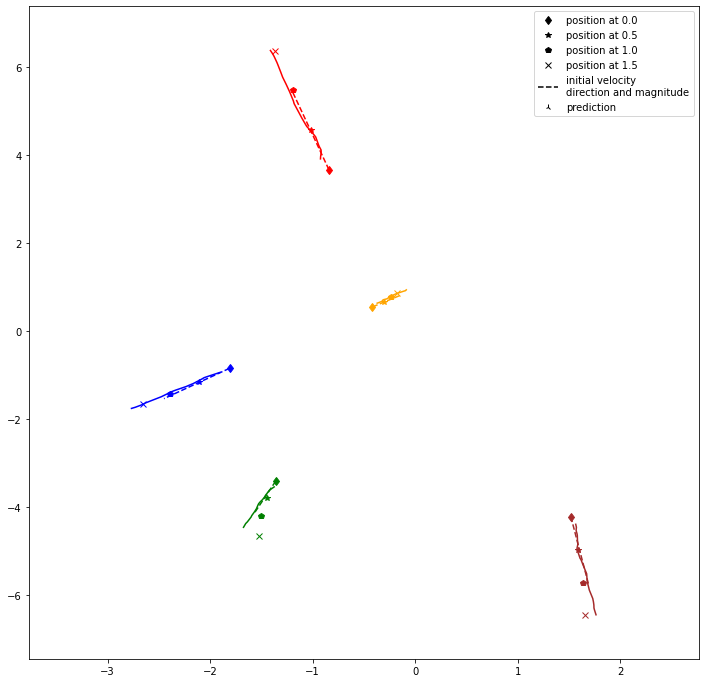

In [28]:
data = data[0].to(device="cpu")
y = y[0].to(device="cpu")

fig = plt.figure()
axes = plt.gca()
axes.set_xlim([-5., 5.])
axes.set_ylim([-5., 5.])
colors = ['red', 'blue', 'green', 'orange', 'brown']
all_x, all_y = list(), list()

for i in range(len(data)):
    plt.plot(data[i][0], data[i][1], 'd', color=colors[i])
    plt.plot(y[i][0], y[i][1], '*', color=colors[i])
    plt.plot(y[i][2], y[i][3], 'p', color=colors[i])
    plt.plot(y[i][4], y[i][5], 'x', color=colors[i])
    plt.plot([data[i][0], data[i][0] + data[i][2]], [data[i][1], data[i][1] + data[i][3]], '--', color=colors[i])
    
    x_pos, y_pos = list(), list()
    for x_x, y_y in zip(exp_x, exp_y):
        x_pos.append(x_x[i])
        y_pos.append(y_y[i])
                    
    all_x.append(x_pos)
    all_y.append(y_pos)
    plt.plot(x_pos, y_pos, color=colors[i])

fig.set_size_inches(12, 12)
plt.xlim(np.min(all_x)-1, np.max(all_x) +1)
plt.ylim(np.min(all_y)-1, np.max(all_y) +1)
plt.plot([], [], 'd', color='black', label='position at 0.0')
plt.plot([], [], '*', color='black', label='position at 0.5')
plt.plot([], [], 'p', color='black', label='position at 1.0')
plt.plot([], [], 'x', color='black', label='position at 1.5')
plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
plt.plot([], [], '2', color='black', label='prediction')
plt.legend()

plt.show()


In [ ]:
import torch.nn as nn

# Evaluate the baseline model (what metrics? r2? rms?)
def rms(p_pred, p_actual):
    '''
    Return the root mean squared distance between predicted locations and actual locations.
    Where p_pred and p_actual are both (N x T x 2 x P) tensors.
    '''
    mse = nn.MSELoss()
    return mse(p_pred, p_actual).sqrt().item()

def baseline_evaluate(p, v, time):
    '''
    Evaluate the baseline "model" at given time in {0, 0.5, 1, 1.5}.
    '''
    p_pred = baseline_predict(p[:, :1, :, :], v, time)
    idx = int(time / 0.5)
    p_actual = p[:, idx:idx+1, :, :]
    # Currently just rms, but we could add more evaluations
    return {'rms': rms(p_pred, p_actual)}

print('Baseline error should be 0:', baseline_evaluate(p_train, v_train, 0))

# Print some more metrics
for klass in ['train', 'valid', 'test']:
    p_klass, v_klass = locals()[f'p_{klass}'], locals()[f'v_{klass}']
    print(f'Error over time should increase ({klass}).')
    for t in [0.5, 1, 1.5]:
        print(f't = {t}', baseline_evaluate(p_train, v_train, t))

Baseline error should be 0: {'rms': 0.0}
Error over time should increase (train).
t = 0.5 {'rms': 0.24874936044216156}
t = 1 {'rms': 0.5171805024147034}
t = 1.5 {'rms': 0.7905893325805664}
Error over time should increase (valid).
t = 0.5 {'rms': 0.24874936044216156}
t = 1 {'rms': 0.5171805024147034}
t = 1.5 {'rms': 0.7905893325805664}
Error over time should increase (test).
t = 0.5 {'rms': 0.24874936044216156}
t = 1 {'rms': 0.5171805024147034}
t = 1.5 {'rms': 0.7905893325805664}


Text(0, 0.5, 'loss value')

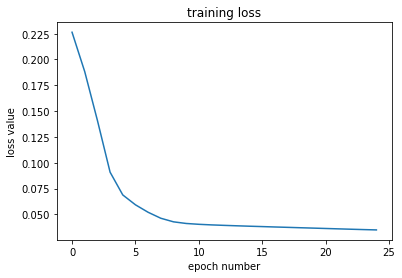

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_graph)
plt.title("training loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")

Text(0, 0.5, 'loss value')

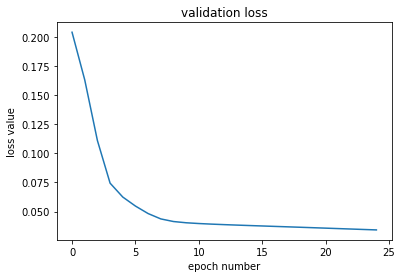

In [ ]:
plt.plot(val_loss_graph)
plt.title("validation loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")

# Model Training

In [ ]:
#todo

# Evaluation

In [ ]:
#TODO:
# The amount of training samples should vary from 100 to 10000, and the
# prediction horizons are t = 0.5, t = 1 and t = 1.5. For each training set
# size/time horizon combination, compare to a simple linear baseline where
# xti = x0i + v0i ·t

In [ ]:
# TODO
# Come up with and execute one additional experiment that provides an interesting insight in your method
# possible idea: interpolation, i.e. given t = 1.5 and t = 0.5, where is it at t = 1?
